In [1]:
import torch
import torch.nn as nn
from torchvision import transforms as T
from torchvision.utils import save_image

In [2]:
## Data Loading
from cifar10 import CIFAR10, get_train_loader, get_test_loader

transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train", transform=transform), batch_size=128)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test", transform=transform), batch_size=64)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 50000, dataloader: 390
train images: torch.Size([128, 3, 32, 32]), torch.float32, -1.0, 1.0
train labels: torch.Size([128]), torch.int64, 0, 9

test dataset: 10000, dataloader: 157
test  images: torch.Size([64, 3, 32, 32]), torch.float32, -1.0, 1.0
test  labels: torch.Size([64]), torch.int64, 0, 9


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_channels=3):
        super().__init__()
        base = 64       # base generator channels
        self.latent_dim = latent_dim
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, base * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(base * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(base * 4, base * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(base * 2, base, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base * 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(base, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        )

    def forward(self, z):
        x = self.net(z)
        return torch.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        base = 64       # base discriminator channels
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, base, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base, base * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base * 2, base * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 1)
        return torch.sigmoid(x)

In [5]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)

In [ ]:
class VanillaGAN(nn.Module):
    def __init__(self, discriminator, generator, latent_dim=None, device=None):
        super().__init__()
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.d_model = discriminator.to(self.device)
        self.g_model = generator.to(self.device)

        self.d_model.apply(self.init_weights)
        self.g_model.apply(self.init_weights)

        self.d_optimizer = torch.optim.Adam(self.d_model.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.g_optimizer = torch.optim.Adam(self.g_model.parameters(), lr=2e-4, betas=(0.5, 0.999))

        self.latent_dim = latent_dim or generator.latent_dim
        self.loss_fn = nn.BCELoss()

    def init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight, 0.0, 0.02)

    def train_step(self, batch):
        batch_size = batch["image"].shape[0]
        real_labels = torch.ones((batch_size, 1)).to(self.device)
        fake_labels = torch.zeros((batch_size, 1)).to(self.device)

        # Train discriminator
        self.d_optimizer.zero_grad()
        real_images = batch["image"].to(self.device)
        real_preds = self.d_model(real_images)
        d_real_loss = self.loss_fn(real_preds, real_labels)
        d_real_loss.backward()

        z = torch.randn(batch_size, self.latent_dim, 1, 1).to(self.device)
        fake_images = self.g_model(z).detach()
        fake_preds = self.d_model(fake_images)
        d_fake_loss = self.loss_fn(fake_preds, fake_labels)
        d_fake_loss.backward()
        self.d_optimizer.step()

        # Train generator
        self.g_optimizer.zero_grad()
        z = torch.randn(batch_size, self.latent_dim, 1, 1).to(self.device)
        fake_images = self.g_model(z)
        fake_preds = self.d_model(fake_images)
        g_loss = self.loss_fn(fake_preds, real_labels)
        g_loss.backward()
        self.g_optimizer.step()

        return dict(real_loss=d_real_loss, fake_loss=d_fake_loss, gen_loss=g_loss)

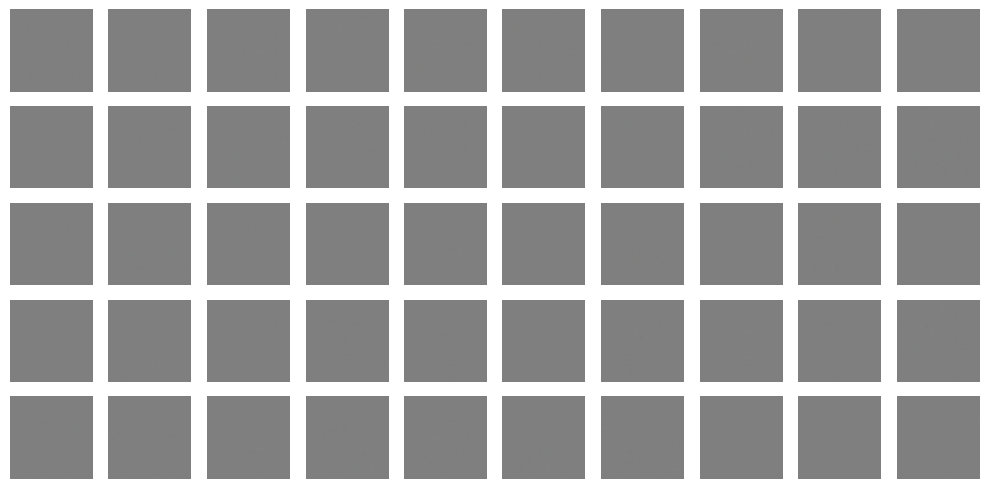

[  1/5] real_loss:0.130, fake_loss:0.122, gen_loss:3.520                                                  
[  2/5] real_loss:0.196, fake_loss:0.175, gen_loss:3.991                                                  
[  3/5] real_loss:0.246, fake_loss:0.226, gen_loss:3.880                                                   
[  4/5] real_loss:0.289, fake_loss:0.279, gen_loss:2.997                                                  
[  5/5] real_loss:0.307, fake_loss:0.303, gen_loss:2.484                                                  


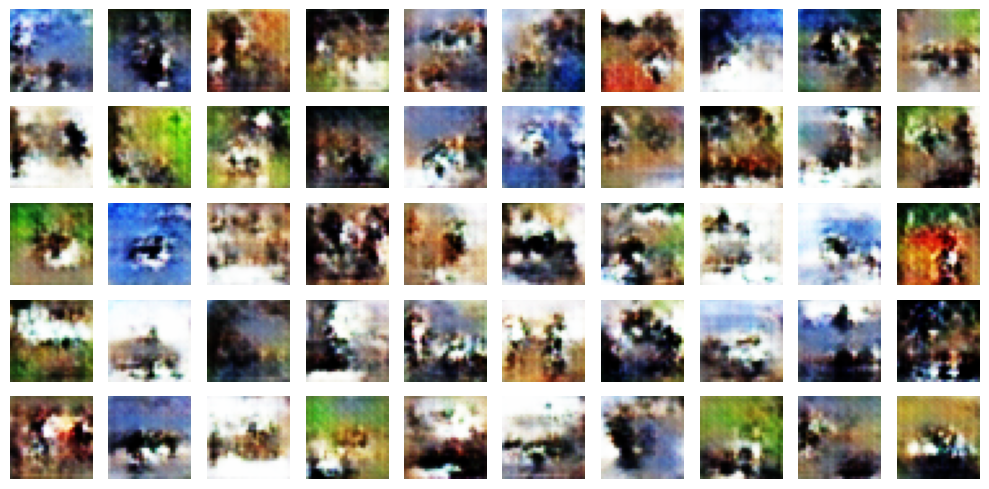

[  1/5] real_loss:0.307, fake_loss:0.296, gen_loss:2.396                                                   
[  2/5] real_loss:0.366, fake_loss:0.358, gen_loss:2.141                                                  
[  3/5] real_loss:0.381, fake_loss:0.388, gen_loss:1.974                                                  
[  4/5] real_loss:0.355, fake_loss:0.357, gen_loss:2.027                                                  
[  5/5] real_loss:0.369, fake_loss:0.376, gen_loss:1.963                                                  


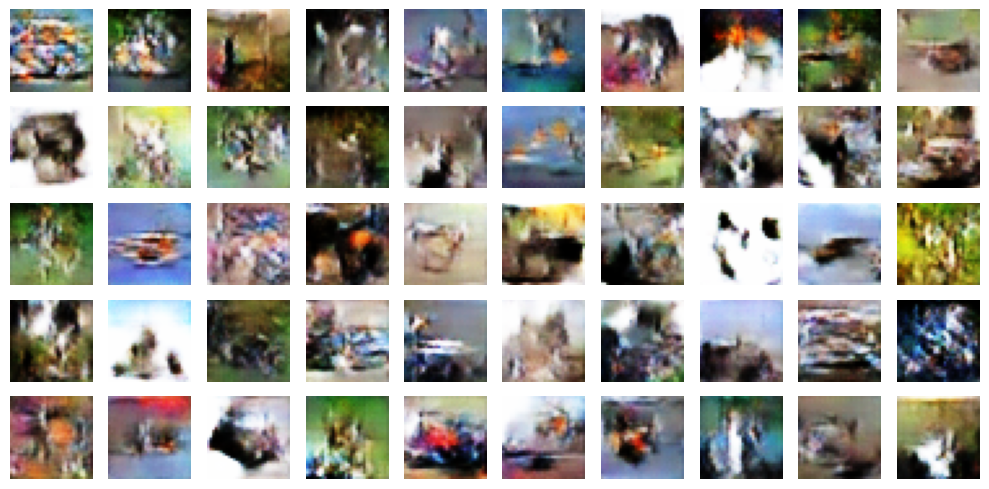

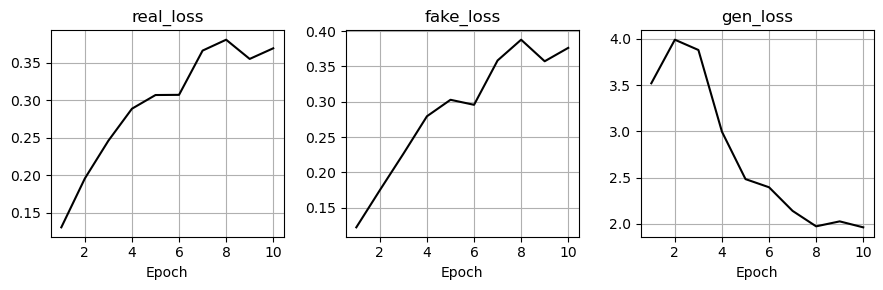

In [8]:
import numpy as np
from trainer import fit
from utils import create_images, plot_images, plot_history

discriminator = Discriminator(in_channels=3)
generator = Generator(latent_dim=100, out_channels=3)
gan = VanillaGAN(discriminator, generator)

z_sample = np.random.normal(size=(50, 100, 1, 1))
# images = create_images(generator, z_sample)
# plot_images(*images, ncols=10, xunit=1, yunit=1)

total_history = {}
for _ in range(2):
    history = fit(gan, train_loader, num_epochs=5)
    for split_name, metrics in history.items():
        total_history.setdefault(split_name, {})
        for metric_name, metric_values in metrics.items():
            total_history[split_name].setdefault(metric_name, [])
            total_history[split_name][metric_name].extend(metric_values)

    images = create_images(generator, z_sample)
    plot_images(*images, ncols=10, xunit=1, yunit=1)

plot_history(total_history["train"])